In [1]:
#!wget -O out.jpg http://fortune.chinanews.com/yl/2015/10-10/U609P4T8D7561304F107DT20151010074348.jpg

(342, 548, 3)


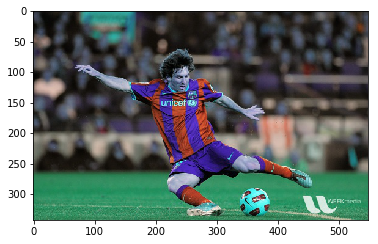

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

img = cv2.imread('messi5.jpg')
print(img.shape)
plt.imshow(img)

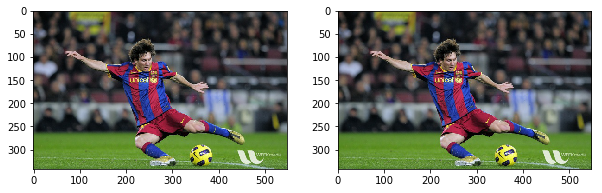

In [3]:
# opencv 默认使用 BGR编码，相比RGB，第三个维度是反的，需要转换为 RGB

# 方法1. 直接操作数组
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(img[:,:,np.array([2,1,0])])
# 方法2. 调用 opencv 函数
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

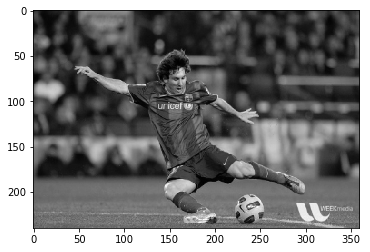

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray_small = cv2.resize(img_gray, (360, 240))
plt.imshow(img_gray_small, cmap="gray")


In [5]:
cv2.imwrite("gray_out.png",img_gray_small)

True

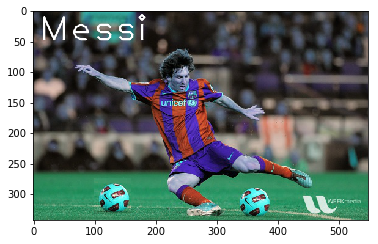

In [6]:
ball = img[280:340, 330:390]
img[273:333, 100:160] = ball
cv2.putText(img,"Messi",(10,50),  cv2.FONT_HERSHEY_PLAIN, 4,(255,255,255),2,cv2.LINE_AA)

plt.imshow(img[:,:,np.array([2,1,0])])

(220, 220)


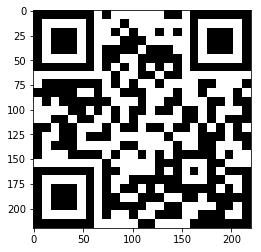

In [7]:
img_jizhiQR = cv2.imread("./3.png")
img_jizhiQR = cv2.cvtColor(img_jizhiQR, cv2.COLOR_BGR2GRAY)
print(img_jizhiQR.shape)
plt.imshow(img_jizhiQR, "gray")

In [8]:
# 看看取值情况，发现只有0（黑色）和 255（白色）
set(img_jizhiQR.ravel())

{0, 255}

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


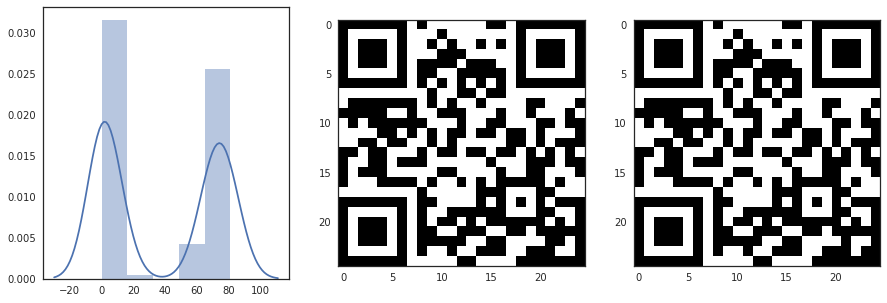

In [9]:
import seaborn as sns
import tensorflow as tf
from sklearn.cluster import KMeans
sns.set_style('white')

def QR_code_to_mat(img_input, num_out):
    np_rawToQr_idx = np.linspace(0, num_out-0.1, img_input.shape[0]).astype(np.int)
    np_rawToQr_mesh = np.meshgrid(np_rawToQr_idx,np_rawToQr_idx)
    np_QR_counts = np.zeros([num_out, num_out])
    for row_idx in range(img_input.shape[0]):
        for col_idx in range(img_input.shape[1]):
            col_num_25 = np_rawToQr_mesh[0][row_idx][col_idx]
            row_num_25 = np_rawToQr_mesh[1][row_idx][col_idx]
            #print(row_idx, col_idx)
            if img_input[row_idx][col_idx] == 255:
                np_QR_counts[row_num_25][col_num_25] += 1
    
    
    return np_QR_counts

def AvgPool(img_input, num_out):
    mat_input = tf.placeholder(tf.float32)
    k_size = int(img_input.shape[0]/num_out)+1
    op = tf.nn.avg_pool(value=mat_input, ksize=[1,9,9,1], strides=[1, 9, 9, 1], padding='SAME')
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        res = (sess.run(op, feed_dict={mat_input: img_input[np.newaxis,:,:,np.newaxis]}))
    
    bigger_label = 1
    kmeans = KMeans(n_clusters=2, random_state=0).fit(res.ravel().reshape(-1,1))
    if kmeans.cluster_centers_[0] > kmeans.cluster_centers_[1]:
        bigger_label = 0
    
    threshold = min(res.ravel()[kmeans.labels_==bigger_label])
    return res[0,:,:,0] > threshold


np_25_counts = QR_code_to_mat(img_jizhiQR, 25)
np_25_counts_tf = AvgPool(img_jizhiQR, 25)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.distplot(np_25_counts.ravel(), ax=ax1)
ax2.imshow(np_25_counts>40, cmap="gray")
ax3.imshow(np_25_counts_tf, cmap="gray")


/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


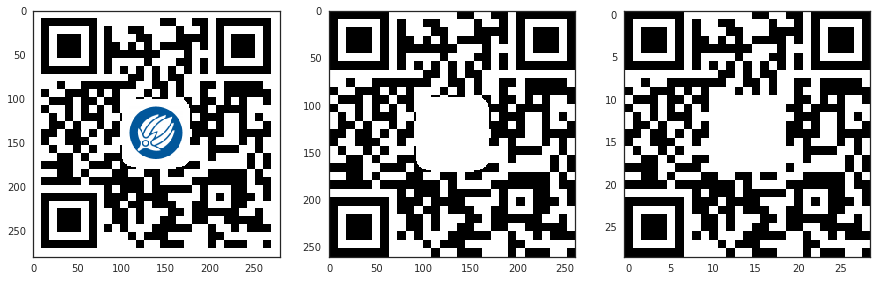

In [10]:
img_jizhiQR = cv2.imread("./jizhi_qinding.png")
img_jizhiQR = img_jizhiQR[:,:,::-1]

# 去掉边缘的白色
img_jizhiQR_gray = cv2.cvtColor(img_jizhiQR, cv2.COLOR_RGB2GRAY)
np_totalRow = np.arange(img_jizhiQR.shape[0])
idx_rowUsed = np_totalRow[img_jizhiQR_gray.mean(0) != 255]
idx_colUsed = np_totalRow[img_jizhiQR_gray.mean(1) != 255]
img_jizhiQR_rmBlank = img_jizhiQR[idx_rowUsed,:,:][:,idx_colUsed,:]

# 去掉蓝色部分
img_jizhiQR_new = np.zeros([img_jizhiQR_rmBlank.shape[0], img_jizhiQR_rmBlank.shape[1]])
idx_black = (img_jizhiQR_rmBlank[:,:,0]<10)*(img_jizhiQR_rmBlank[:,:,1]<10)*(img_jizhiQR_rmBlank[:,:,2]<10)
img_jizhiQR_new[idx_black] = 255
np_25_counts_tf = AvgPool(img_jizhiQR_new, 29)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.imshow(img_jizhiQR)
ax2.imshow(img_jizhiQR_new)
ax3.imshow(np_25_counts_tf)

In [11]:
ball.shape

(60, 60, 3)

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


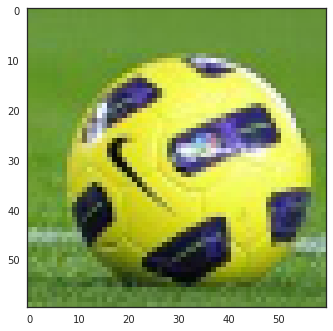

In [12]:
plt.imshow(ball)

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


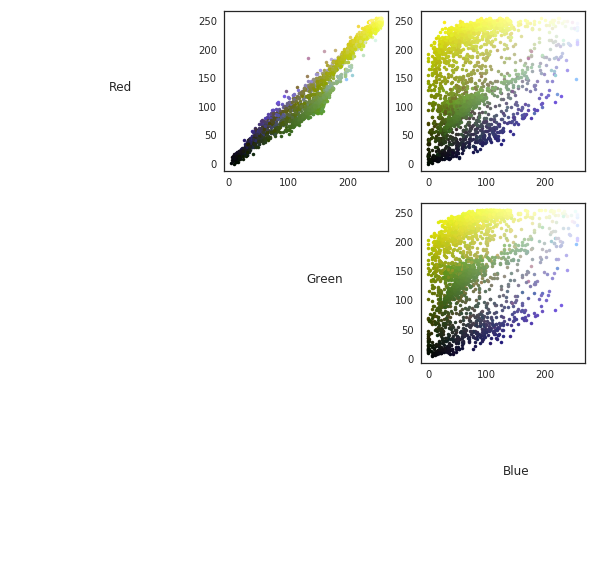

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(332)
for r in ball.reshape(-1, 3):
    ax.plot(r[1], r[0], '.', c=(r[0]/255., r[1]/255., r[2]/255.) )
    
ax = fig.add_subplot(333)
for r in ball.reshape(-1, 3):
    ax.plot(r[2], r[0], '.', c=(r[0]/255., r[1]/255., r[2]/255.) )
    
ax = fig.add_subplot(336)
for r in ball.reshape(-1, 3):
    ax.plot(r[2], r[1], '.', c=(r[0]/255., r[1]/255., r[2]/255.) )
    
for i,color in enumerate(['Red', "Green", "Blue"]):
    ax = fig.add_subplot(3,3,i*3+i+1)
    ax.text(5,5, color)
    ax.plot(0,0)
    ax.plot(10,10)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


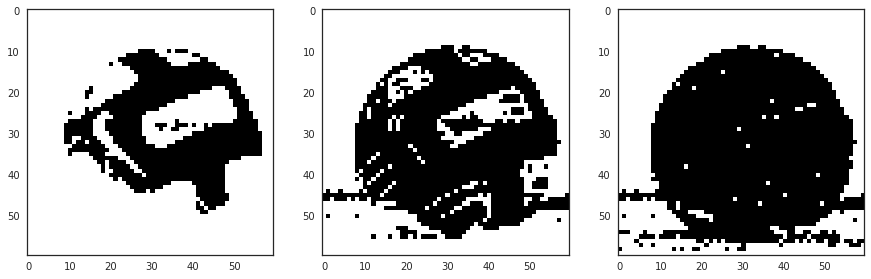

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow( (ball[:,:,0]>200) )
ax2.imshow( (ball[:,:,0]>130)+(ball[:,:,0]<50) )
ax3.imshow( (ball[:,:,0]>130)+(ball[:,:,0]<50)+(ball[:,:,1]<120) )

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


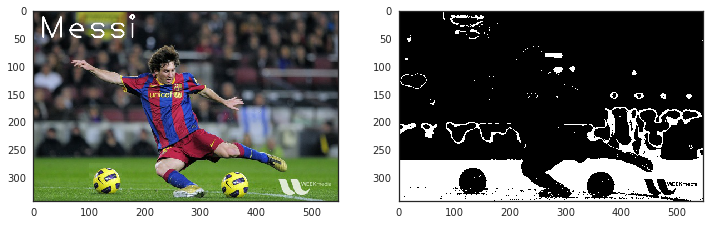

In [15]:
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

img1 = ((img[:,:,0]>130)+(img[:,:,0]<50)+(img[:,:,1]<120)).astype(np.uint8)
ax1.imshow(img)
ax2.imshow(img1)

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


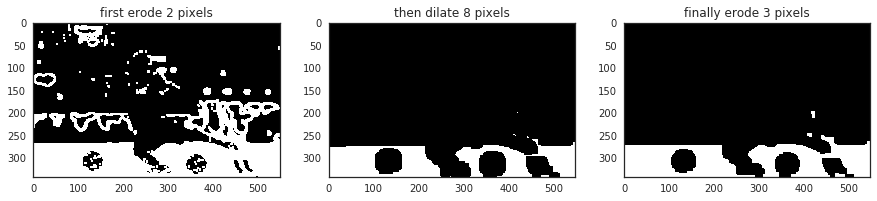

In [16]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))

img_e   = cv2.erode(img1, kernel, iterations=2)
img_de  = cv2.dilate(img_e, kernel, iterations=8)
img_ede = cv2.erode(img_de, kernel, iterations=3)
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.imshow(img_e)
ax2.imshow(img_de)
ax3.imshow(img_ede)
ax1.set_title(u"first erode 2 pixels")
ax2.set_title(u"then dilate 8 pixels")
ax3.set_title(u"finally erode 3 pixels")

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


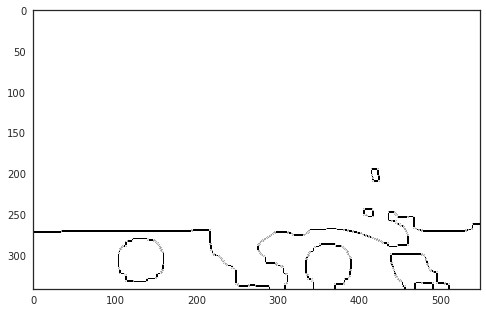

In [17]:
sobelx = cv2.Sobel(img_ede*255, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(img_ede*255, cv2.CV_64F, 0, 1)
img_sob = np.sqrt(sobelx**2+sobely**2).astype(np.uint8)
plt.imshow(img_sob)

/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


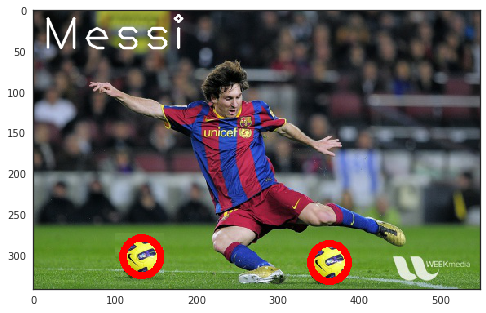

In [18]:
gray = img_sob
canny = cv2.Canny(gray, 200, 300)
gray = cv2.medianBlur(gray, 5)
np_hc = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=60,
              param1=200,
              param2=10,
              minRadius=20,
              maxRadius=30)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img_sob, "gray")
img_tmp = np_hc
for i in range(np_hc.shape[1]):
    img_tmp = cv2.circle(img, (np_hc[0,i,0],np_hc[0,i,1]), np_hc[0,i,2], (255, 0, 0), 8)

plt.imshow(img_tmp)


In [19]:
!wget -O ./udacity_vehicle.tar.gz http://dl4img-1251985129.cosbj.myqcloud.com/udacity_vehicle.tar.gz
!mkdir -p ./dataset
!tar -zxvf udacity_vehicle.tar.gz -C ./dataset

--2017-10-09 12:22:06--  http://dl4img-1251985129.cosbj.myqcloud.com/udacity_vehicle.tar.gz
Resolving dl4img-1251985129.cosbj.myqcloud.com (dl4img-1251985129.cosbj.myqcloud.com)... 211.159.137.25, 211.159.136.24, 211.159.136.25, ...
Connecting to dl4img-1251985129.cosbj.myqcloud.com (dl4img-1251985129.cosbj.myqcloud.com)|211.159.137.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122238706 (117M) [application/octet-stream]
Saving to: './udacity_vehicle.tar.gz'

100%[======================================>] 122,238,706  620KB/s   in 2m 12s 

2017-10-09 12:24:18 (902 KB/s) - './udacity_vehicle.tar.gz' saved [122238706/122238706]

./._non-vehicles
non-vehicles/
non-vehicles/._.DS_Store
non-vehicles/.DS_Store
non-vehicles/._Extras
non-vehicles/Extras/
non-vehicles/._GTI
non-vehicles/GTI/
non-vehicles/GTI/._.DS_Store
non-vehicles/GTI/.DS_Store
non-vehicles/GTI/._image1.png
non-vehicles/GTI/image1.png
non-vehicles/GTI/._image10.png
non-vehicles/GTI/image10.png
non

non-vehicles/GTI/image126.png
non-vehicles/GTI/._image1260.png
non-vehicles/GTI/image1260.png
non-vehicles/GTI/._image1261.png
non-vehicles/GTI/image1261.png
non-vehicles/GTI/._image1262.png
non-vehicles/GTI/image1262.png
non-vehicles/GTI/._image1263.png
non-vehicles/GTI/image1263.png
non-vehicles/GTI/._image1264.png
non-vehicles/GTI/image1264.png
non-vehicles/GTI/._image1265.png
non-vehicles/GTI/image1265.png
non-vehicles/GTI/._image1266.png
non-vehicles/GTI/image1266.png
non-vehicles/GTI/._image1267.png
non-vehicles/GTI/image1267.png
non-vehicles/GTI/._image1268.png
non-vehicles/GTI/image1268.png
non-vehicles/GTI/._image1269.png
non-vehicles/GTI/image1269.png
non-vehicles/GTI/._image127.png
non-vehicles/GTI/image127.png
non-vehicles/GTI/._image1270.png
non-vehicles/GTI/image1270.png
non-vehicles/GTI/._image1271.png
non-vehicles/GTI/image1271.png
non-vehicles/GTI/._image1272.png
non-vehicles/GTI/image1272.png
non-vehicles/GTI/._image1273.png
non-vehicles/GTI/image1273.png
non-vehicles

non-vehicles/GTI/image1608.png
non-vehicles/GTI/._image1609.png
non-vehicles/GTI/image1609.png
non-vehicles/GTI/._image161.png
non-vehicles/GTI/image161.png
non-vehicles/GTI/._image1610.png
non-vehicles/GTI/image1610.png
non-vehicles/GTI/._image1611.png
non-vehicles/GTI/image1611.png
non-vehicles/GTI/._image1612.png
non-vehicles/GTI/image1612.png
non-vehicles/GTI/._image1613.png
non-vehicles/GTI/image1613.png
non-vehicles/GTI/._image1614.png
non-vehicles/GTI/image1614.png
non-vehicles/GTI/._image1615.png
non-vehicles/GTI/image1615.png
non-vehicles/GTI/._image1616.png
non-vehicles/GTI/image1616.png
non-vehicles/GTI/._image1617.png
non-vehicles/GTI/image1617.png
non-vehicles/GTI/._image1618.png
non-vehicles/GTI/image1618.png
non-vehicles/GTI/._image1619.png
non-vehicles/GTI/image1619.png
non-vehicles/GTI/._image162.png
non-vehicles/GTI/image162.png
non-vehicles/GTI/._image1620.png
non-vehicles/GTI/image1620.png
non-vehicles/GTI/._image1621.png
non-vehicles/GTI/image1621.png
non-vehicles/

non-vehicles/GTI/._image2018.png
non-vehicles/GTI/image2018.png
non-vehicles/GTI/._image2019.png
non-vehicles/GTI/image2019.png
non-vehicles/GTI/._image202.png
non-vehicles/GTI/image202.png
non-vehicles/GTI/._image2020.png
non-vehicles/GTI/image2020.png
non-vehicles/GTI/._image2021.png
non-vehicles/GTI/image2021.png
non-vehicles/GTI/._image2022.png
non-vehicles/GTI/image2022.png
non-vehicles/GTI/._image2023.png
non-vehicles/GTI/image2023.png
non-vehicles/GTI/._image2024.png
non-vehicles/GTI/image2024.png
non-vehicles/GTI/._image2025.png
non-vehicles/GTI/image2025.png
non-vehicles/GTI/._image2026.png
non-vehicles/GTI/image2026.png
non-vehicles/GTI/._image2027.png
non-vehicles/GTI/image2027.png
non-vehicles/GTI/._image2028.png
non-vehicles/GTI/image2028.png
non-vehicles/GTI/._image2029.png
non-vehicles/GTI/image2029.png
non-vehicles/GTI/._image203.png
non-vehicles/GTI/image203.png
non-vehicles/GTI/._image2030.png
non-vehicles/GTI/image2030.png
non-vehicles/GTI/._image2031.png
non-vehicle

non-vehicles/GTI/image259.png
non-vehicles/GTI/._image2590.png
non-vehicles/GTI/image2590.png
non-vehicles/GTI/._image2591.png
non-vehicles/GTI/image2591.png
non-vehicles/GTI/._image2592.png
non-vehicles/GTI/image2592.png
non-vehicles/GTI/._image2593.png
non-vehicles/GTI/image2593.png
non-vehicles/GTI/._image2594.png
non-vehicles/GTI/image2594.png
non-vehicles/GTI/._image2595.png
non-vehicles/GTI/image2595.png
non-vehicles/GTI/._image2596.png
non-vehicles/GTI/image2596.png
non-vehicles/GTI/._image2597.png
non-vehicles/GTI/image2597.png
non-vehicles/GTI/._image2598.png
non-vehicles/GTI/image2598.png
non-vehicles/GTI/._image2599.png
non-vehicles/GTI/image2599.png
non-vehicles/GTI/._image26.png
non-vehicles/GTI/image26.png
non-vehicles/GTI/._image260.png
non-vehicles/GTI/image260.png
non-vehicles/GTI/._image2600.png
non-vehicles/GTI/image2600.png
non-vehicles/GTI/._image2601.png
non-vehicles/GTI/image2601.png
non-vehicles/GTI/._image2602.png
non-vehicles/GTI/image2602.png
non-vehicles/GTI

non-vehicles/GTI/image3225.png
non-vehicles/GTI/._image3226.png
non-vehicles/GTI/image3226.png
non-vehicles/GTI/._image3227.png
non-vehicles/GTI/image3227.png
non-vehicles/GTI/._image3228.png
non-vehicles/GTI/image3228.png
non-vehicles/GTI/._image3229.png
non-vehicles/GTI/image3229.png
non-vehicles/GTI/._image323.png
non-vehicles/GTI/image323.png
non-vehicles/GTI/._image3230.png
non-vehicles/GTI/image3230.png
non-vehicles/GTI/._image3231.png
non-vehicles/GTI/image3231.png
non-vehicles/GTI/._image3232.png
non-vehicles/GTI/image3232.png
non-vehicles/GTI/._image3233.png
non-vehicles/GTI/image3233.png
non-vehicles/GTI/._image3234.png
non-vehicles/GTI/image3234.png
non-vehicles/GTI/._image3235.png
non-vehicles/GTI/image3235.png
non-vehicles/GTI/._image3236.png
non-vehicles/GTI/image3236.png
non-vehicles/GTI/._image3237.png
non-vehicles/GTI/image3237.png
non-vehicles/GTI/._image3238.png
non-vehicles/GTI/image3238.png
non-vehicles/GTI/._image3239.png
non-vehicles/GTI/image3239.png
non-vehicle

non-vehicles/GTI/._image3859.png
non-vehicles/GTI/image3859.png
non-vehicles/GTI/._image386.png
non-vehicles/GTI/image386.png
non-vehicles/GTI/._image3860.png
non-vehicles/GTI/image3860.png
non-vehicles/GTI/._image3861.png
non-vehicles/GTI/image3861.png
non-vehicles/GTI/._image3862.png
non-vehicles/GTI/image3862.png
non-vehicles/GTI/._image3863.png
non-vehicles/GTI/image3863.png
non-vehicles/GTI/._image3864.png
non-vehicles/GTI/image3864.png
non-vehicles/GTI/._image3865.png
non-vehicles/GTI/image3865.png
non-vehicles/GTI/._image3866.png
non-vehicles/GTI/image3866.png
non-vehicles/GTI/._image3867.png
non-vehicles/GTI/image3867.png
non-vehicles/GTI/._image3868.png
non-vehicles/GTI/image3868.png
non-vehicles/GTI/._image3869.png
non-vehicles/GTI/image3869.png
non-vehicles/GTI/._image387.png
non-vehicles/GTI/image387.png
non-vehicles/GTI/._image3870.png
non-vehicles/GTI/image3870.png
non-vehicles/GTI/._image3871.png
non-vehicles/GTI/image3871.png
non-vehicles/GTI/._image3872.png
non-vehicle

non-vehicles/GTI/._image95.png
non-vehicles/GTI/image95.png
non-vehicles/GTI/._image950.png
non-vehicles/GTI/image950.png
non-vehicles/GTI/._image951.png
non-vehicles/GTI/image951.png
non-vehicles/GTI/._image952.png
non-vehicles/GTI/image952.png
non-vehicles/GTI/._image953.png
non-vehicles/GTI/image953.png
non-vehicles/GTI/._image954.png
non-vehicles/GTI/image954.png
non-vehicles/GTI/._image955.png
non-vehicles/GTI/image955.png
non-vehicles/GTI/._image956.png
non-vehicles/GTI/image956.png
non-vehicles/GTI/._image957.png
non-vehicles/GTI/image957.png
non-vehicles/GTI/._image958.png
non-vehicles/GTI/image958.png
non-vehicles/GTI/._image959.png
non-vehicles/GTI/image959.png
non-vehicles/GTI/._image96.png
non-vehicles/GTI/image96.png
non-vehicles/GTI/._image960.png
non-vehicles/GTI/image960.png
non-vehicles/GTI/._image961.png
non-vehicles/GTI/image961.png
non-vehicles/GTI/._image962.png
non-vehicles/GTI/image962.png
non-vehicles/GTI/._image963.png
non-vehicles/GTI/image963.png
non-vehicles

non-vehicles/Extras/extra1675.png
non-vehicles/Extras/._extra1676.png
non-vehicles/Extras/extra1676.png
non-vehicles/Extras/._extra1677.png
non-vehicles/Extras/extra1677.png
non-vehicles/Extras/._extra1678.png
non-vehicles/Extras/extra1678.png
non-vehicles/Extras/._extra1679.png
non-vehicles/Extras/extra1679.png
non-vehicles/Extras/._extra168.png
non-vehicles/Extras/extra168.png
non-vehicles/Extras/._extra1680.png
non-vehicles/Extras/extra1680.png
non-vehicles/Extras/._extra1681.png
non-vehicles/Extras/extra1681.png
non-vehicles/Extras/._extra1682.png
non-vehicles/Extras/extra1682.png
non-vehicles/Extras/._extra1683.png
non-vehicles/Extras/extra1683.png
non-vehicles/Extras/._extra1684.png
non-vehicles/Extras/extra1684.png
non-vehicles/Extras/._extra1685.png
non-vehicles/Extras/extra1685.png
non-vehicles/Extras/._extra1686.png
non-vehicles/Extras/extra1686.png
non-vehicles/Extras/._extra1687.png
non-vehicles/Extras/extra1687.png
non-vehicles/Extras/._extra1688.png
non-vehicles/Extras/ex

non-vehicles/Extras/extra2459.png
non-vehicles/Extras/._extra246.png
non-vehicles/Extras/extra246.png
non-vehicles/Extras/._extra2460.png
non-vehicles/Extras/extra2460.png
non-vehicles/Extras/._extra2461.png
non-vehicles/Extras/extra2461.png
non-vehicles/Extras/._extra2462.png
non-vehicles/Extras/extra2462.png
non-vehicles/Extras/._extra2463.png
non-vehicles/Extras/extra2463.png
non-vehicles/Extras/._extra2464.png
non-vehicles/Extras/extra2464.png
non-vehicles/Extras/._extra2465.png
non-vehicles/Extras/extra2465.png
non-vehicles/Extras/._extra2466.png
non-vehicles/Extras/extra2466.png
non-vehicles/Extras/._extra2467.png
non-vehicles/Extras/extra2467.png
non-vehicles/Extras/._extra2468.png
non-vehicles/Extras/extra2468.png
non-vehicles/Extras/._extra2469.png
non-vehicles/Extras/extra2469.png
non-vehicles/Extras/._extra247.png
non-vehicles/Extras/extra247.png
non-vehicles/Extras/._extra2470.png
non-vehicles/Extras/extra2470.png
non-vehicles/Extras/._extra2471.png
non-vehicles/Extras/extr

non-vehicles/Extras/._extra3199.png
non-vehicles/Extras/extra3199.png
non-vehicles/Extras/._extra320.png
non-vehicles/Extras/extra320.png
non-vehicles/Extras/._extra3200.png
non-vehicles/Extras/extra3200.png
non-vehicles/Extras/._extra3201.png
non-vehicles/Extras/extra3201.png
non-vehicles/Extras/._extra3202.png
non-vehicles/Extras/extra3202.png
non-vehicles/Extras/._extra3203.png
non-vehicles/Extras/extra3203.png
non-vehicles/Extras/._extra3204.png
non-vehicles/Extras/extra3204.png
non-vehicles/Extras/._extra3205.png
non-vehicles/Extras/extra3205.png
non-vehicles/Extras/._extra3206.png
non-vehicles/Extras/extra3206.png
non-vehicles/Extras/._extra3207.png
non-vehicles/Extras/extra3207.png
non-vehicles/Extras/._extra3208.png
non-vehicles/Extras/extra3208.png
non-vehicles/Extras/._extra3209.png
non-vehicles/Extras/extra3209.png
non-vehicles/Extras/._extra321.png
non-vehicles/Extras/extra321.png
non-vehicles/Extras/._extra3210.png
non-vehicles/Extras/extra3210.png
non-vehicles/Extras/._ex

non-vehicles/Extras/._extra3711.png
non-vehicles/Extras/extra3711.png
non-vehicles/Extras/._extra3712.png
non-vehicles/Extras/extra3712.png
non-vehicles/Extras/._extra3713.png
non-vehicles/Extras/extra3713.png
non-vehicles/Extras/._extra3714.png
non-vehicles/Extras/extra3714.png
non-vehicles/Extras/._extra3715.png
non-vehicles/Extras/extra3715.png
non-vehicles/Extras/._extra3716.png
non-vehicles/Extras/extra3716.png
non-vehicles/Extras/._extra3717.png
non-vehicles/Extras/extra3717.png
non-vehicles/Extras/._extra3718.png
non-vehicles/Extras/extra3718.png
non-vehicles/Extras/._extra3719.png
non-vehicles/Extras/extra3719.png
non-vehicles/Extras/._extra372.png
non-vehicles/Extras/extra372.png
non-vehicles/Extras/._extra3720.png
non-vehicles/Extras/extra3720.png
non-vehicles/Extras/._extra3721.png
non-vehicles/Extras/extra3721.png
non-vehicles/Extras/._extra3722.png
non-vehicles/Extras/extra3722.png
non-vehicles/Extras/._extra3723.png
non-vehicles/Extras/extra3723.png
non-vehicles/Extras/._

non-vehicles/Extras/extra3948.png
non-vehicles/Extras/._extra3949.png
non-vehicles/Extras/extra3949.png
non-vehicles/Extras/._extra395.png
non-vehicles/Extras/extra395.png
non-vehicles/Extras/._extra3950.png
non-vehicles/Extras/extra3950.png
non-vehicles/Extras/._extra3951.png
non-vehicles/Extras/extra3951.png
non-vehicles/Extras/._extra3953.png
non-vehicles/Extras/extra3953.png
non-vehicles/Extras/._extra3954.png
non-vehicles/Extras/extra3954.png
non-vehicles/Extras/._extra3955.png
non-vehicles/Extras/extra3955.png
non-vehicles/Extras/._extra3956.png
non-vehicles/Extras/extra3956.png
non-vehicles/Extras/._extra3957.png
non-vehicles/Extras/extra3957.png
non-vehicles/Extras/._extra3958.png
non-vehicles/Extras/extra3958.png
non-vehicles/Extras/._extra3959.png
non-vehicles/Extras/extra3959.png
non-vehicles/Extras/._extra396.png
non-vehicles/Extras/extra396.png
non-vehicles/Extras/._extra3960.png
non-vehicles/Extras/extra3960.png
non-vehicles/Extras/._extra3961.png
non-vehicles/Extras/extr

non-vehicles/Extras/extra4460.png
non-vehicles/Extras/._extra4461.png
non-vehicles/Extras/extra4461.png
non-vehicles/Extras/._extra4462.png
non-vehicles/Extras/extra4462.png
non-vehicles/Extras/._extra4463.png
non-vehicles/Extras/extra4463.png
non-vehicles/Extras/._extra4464.png
non-vehicles/Extras/extra4464.png
non-vehicles/Extras/._extra4465.png
non-vehicles/Extras/extra4465.png
non-vehicles/Extras/._extra4466.png
non-vehicles/Extras/extra4466.png
non-vehicles/Extras/._extra4467.png
non-vehicles/Extras/extra4467.png
non-vehicles/Extras/._extra4468.png
non-vehicles/Extras/extra4468.png
non-vehicles/Extras/._extra4469.png
non-vehicles/Extras/extra4469.png
non-vehicles/Extras/._extra447.png
non-vehicles/Extras/extra447.png
non-vehicles/Extras/._extra4470.png
non-vehicles/Extras/extra4470.png
non-vehicles/Extras/._extra4471.png
non-vehicles/Extras/extra4471.png
non-vehicles/Extras/._extra4472.png
non-vehicles/Extras/extra4472.png
non-vehicles/Extras/._extra4473.png
non-vehicles/Extras/ex

non-vehicles/Extras/extra5006.png
non-vehicles/Extras/._extra5007.png
non-vehicles/Extras/extra5007.png
non-vehicles/Extras/._extra5008.png
non-vehicles/Extras/extra5008.png
non-vehicles/Extras/._extra5009.png
non-vehicles/Extras/extra5009.png
non-vehicles/Extras/._extra501.png
non-vehicles/Extras/extra501.png
non-vehicles/Extras/._extra5010.png
non-vehicles/Extras/extra5010.png
non-vehicles/Extras/._extra5011.png
non-vehicles/Extras/extra5011.png
non-vehicles/Extras/._extra5012.png
non-vehicles/Extras/extra5012.png
non-vehicles/Extras/._extra5013.png
non-vehicles/Extras/extra5013.png
non-vehicles/Extras/._extra5014.png
non-vehicles/Extras/extra5014.png
non-vehicles/Extras/._extra5015.png
non-vehicles/Extras/extra5015.png
non-vehicles/Extras/._extra5016.png
non-vehicles/Extras/extra5016.png
non-vehicles/Extras/._extra5017.png
non-vehicles/Extras/extra5017.png
non-vehicles/Extras/._extra5018.png
non-vehicles/Extras/extra5018.png
non-vehicles/Extras/._extra5019.png
non-vehicles/Extras/ex

non-vehicles/Extras/extra5592.png
non-vehicles/Extras/._extra5593.png
non-vehicles/Extras/extra5593.png
non-vehicles/Extras/._extra5594.png
non-vehicles/Extras/extra5594.png
non-vehicles/Extras/._extra5595.png
non-vehicles/Extras/extra5595.png
non-vehicles/Extras/._extra5596.png
non-vehicles/Extras/extra5596.png
non-vehicles/Extras/._extra5597.png
non-vehicles/Extras/extra5597.png
non-vehicles/Extras/._extra5598.png
non-vehicles/Extras/extra5598.png
non-vehicles/Extras/._extra5599.png
non-vehicles/Extras/extra5599.png
non-vehicles/Extras/._extra56.png
non-vehicles/Extras/extra56.png
non-vehicles/Extras/._extra560.png
non-vehicles/Extras/extra560.png
non-vehicles/Extras/._extra5600.png
non-vehicles/Extras/extra5600.png
non-vehicles/Extras/._extra5601.png
non-vehicles/Extras/extra5601.png
non-vehicles/Extras/._extra5602.png
non-vehicles/Extras/extra5602.png
non-vehicles/Extras/._extra5603.png
non-vehicles/Extras/extra5603.png
non-vehicles/Extras/._extra5604.png
non-vehicles/Extras/extra5

vehicles/KITTI_extracted/108.png
vehicles/KITTI_extracted/._1080.png
vehicles/KITTI_extracted/1080.png
vehicles/KITTI_extracted/._1081.png
vehicles/KITTI_extracted/1081.png
vehicles/KITTI_extracted/._1082.png
vehicles/KITTI_extracted/1082.png
vehicles/KITTI_extracted/._1083.png
vehicles/KITTI_extracted/1083.png
vehicles/KITTI_extracted/._1084.png
vehicles/KITTI_extracted/1084.png
vehicles/KITTI_extracted/._1085.png
vehicles/KITTI_extracted/1085.png
vehicles/KITTI_extracted/._1086.png
vehicles/KITTI_extracted/1086.png
vehicles/KITTI_extracted/._1087.png
vehicles/KITTI_extracted/1087.png
vehicles/KITTI_extracted/._1088.png
vehicles/KITTI_extracted/1088.png
vehicles/KITTI_extracted/._1089.png
vehicles/KITTI_extracted/1089.png
vehicles/KITTI_extracted/._109.png
vehicles/KITTI_extracted/109.png
vehicles/KITTI_extracted/._1090.png
vehicles/KITTI_extracted/1090.png
vehicles/KITTI_extracted/._1091.png
vehicles/KITTI_extracted/1091.png
vehicles/KITTI_extracted/._1092.png
vehicles/KITTI_extracte

vehicles/KITTI_extracted/._1772.png
vehicles/KITTI_extracted/1772.png
vehicles/KITTI_extracted/._1773.png
vehicles/KITTI_extracted/1773.png
vehicles/KITTI_extracted/._1774.png
vehicles/KITTI_extracted/1774.png
vehicles/KITTI_extracted/._1775.png
vehicles/KITTI_extracted/1775.png
vehicles/KITTI_extracted/._1776.png
vehicles/KITTI_extracted/1776.png
vehicles/KITTI_extracted/._1777.png
vehicles/KITTI_extracted/1777.png
vehicles/KITTI_extracted/._1778.png
vehicles/KITTI_extracted/1778.png
vehicles/KITTI_extracted/._1779.png
vehicles/KITTI_extracted/1779.png
vehicles/KITTI_extracted/._178.png
vehicles/KITTI_extracted/178.png
vehicles/KITTI_extracted/._1780.png
vehicles/KITTI_extracted/1780.png
vehicles/KITTI_extracted/._1781.png
vehicles/KITTI_extracted/1781.png
vehicles/KITTI_extracted/._1782.png
vehicles/KITTI_extracted/1782.png
vehicles/KITTI_extracted/._1783.png
vehicles/KITTI_extracted/1783.png
vehicles/KITTI_extracted/._1784.png
vehicles/KITTI_extracted/1784.png
vehicles/KITTI_extract

vehicles/KITTI_extracted/._2455.png
vehicles/KITTI_extracted/2455.png
vehicles/KITTI_extracted/._2456.png
vehicles/KITTI_extracted/2456.png
vehicles/KITTI_extracted/._2457.png
vehicles/KITTI_extracted/2457.png
vehicles/KITTI_extracted/._2458.png
vehicles/KITTI_extracted/2458.png
vehicles/KITTI_extracted/._2459.png
vehicles/KITTI_extracted/2459.png
vehicles/KITTI_extracted/._246.png
vehicles/KITTI_extracted/246.png
vehicles/KITTI_extracted/._2460.png
vehicles/KITTI_extracted/2460.png
vehicles/KITTI_extracted/._2461.png
vehicles/KITTI_extracted/2461.png
vehicles/KITTI_extracted/._2462.png
vehicles/KITTI_extracted/2462.png
vehicles/KITTI_extracted/._2463.png
vehicles/KITTI_extracted/2463.png
vehicles/KITTI_extracted/._2464.png
vehicles/KITTI_extracted/2464.png
vehicles/KITTI_extracted/._2465.png
vehicles/KITTI_extracted/2465.png
vehicles/KITTI_extracted/._2466.png
vehicles/KITTI_extracted/2466.png
vehicles/KITTI_extracted/._2467.png
vehicles/KITTI_extracted/2467.png
vehicles/KITTI_extract

vehicles/KITTI_extracted/._3131.png
vehicles/KITTI_extracted/3131.png
vehicles/KITTI_extracted/._3132.png
vehicles/KITTI_extracted/3132.png
vehicles/KITTI_extracted/._3133.png
vehicles/KITTI_extracted/3133.png
vehicles/KITTI_extracted/._3134.png
vehicles/KITTI_extracted/3134.png
vehicles/KITTI_extracted/._3135.png
vehicles/KITTI_extracted/3135.png
vehicles/KITTI_extracted/._3136.png
vehicles/KITTI_extracted/3136.png
vehicles/KITTI_extracted/._3137.png
vehicles/KITTI_extracted/3137.png
vehicles/KITTI_extracted/._3138.png
vehicles/KITTI_extracted/3138.png
vehicles/KITTI_extracted/._3139.png
vehicles/KITTI_extracted/3139.png
vehicles/KITTI_extracted/._314.png
vehicles/KITTI_extracted/314.png
vehicles/KITTI_extracted/._3140.png
vehicles/KITTI_extracted/3140.png
vehicles/KITTI_extracted/._3141.png
vehicles/KITTI_extracted/3141.png
vehicles/KITTI_extracted/._3142.png
vehicles/KITTI_extracted/3142.png
vehicles/KITTI_extracted/._3143.png
vehicles/KITTI_extracted/3143.png
vehicles/KITTI_extract

vehicles/KITTI_extracted/3808.png
vehicles/KITTI_extracted/._3809.png
vehicles/KITTI_extracted/3809.png
vehicles/KITTI_extracted/._381.png
vehicles/KITTI_extracted/381.png
vehicles/KITTI_extracted/._3810.png
vehicles/KITTI_extracted/3810.png
vehicles/KITTI_extracted/._3811.png
vehicles/KITTI_extracted/3811.png
vehicles/KITTI_extracted/._3812.png
vehicles/KITTI_extracted/3812.png
vehicles/KITTI_extracted/._3813.png
vehicles/KITTI_extracted/3813.png
vehicles/KITTI_extracted/._3814.png
vehicles/KITTI_extracted/3814.png
vehicles/KITTI_extracted/._3815.png
vehicles/KITTI_extracted/3815.png
vehicles/KITTI_extracted/._3816.png
vehicles/KITTI_extracted/3816.png
vehicles/KITTI_extracted/._3817.png
vehicles/KITTI_extracted/3817.png
vehicles/KITTI_extracted/._3818.png
vehicles/KITTI_extracted/3818.png
vehicles/KITTI_extracted/._3819.png
vehicles/KITTI_extracted/3819.png
vehicles/KITTI_extracted/._382.png
vehicles/KITTI_extracted/382.png
vehicles/KITTI_extracted/._3820.png
vehicles/KITTI_extracted

vehicles/KITTI_extracted/._4475.png
vehicles/KITTI_extracted/4475.png
vehicles/KITTI_extracted/._4476.png
vehicles/KITTI_extracted/4476.png
vehicles/KITTI_extracted/._4477.png
vehicles/KITTI_extracted/4477.png
vehicles/KITTI_extracted/._4478.png
vehicles/KITTI_extracted/4478.png
vehicles/KITTI_extracted/._4479.png
vehicles/KITTI_extracted/4479.png
vehicles/KITTI_extracted/._448.png
vehicles/KITTI_extracted/448.png
vehicles/KITTI_extracted/._4480.png
vehicles/KITTI_extracted/4480.png
vehicles/KITTI_extracted/._4481.png
vehicles/KITTI_extracted/4481.png
vehicles/KITTI_extracted/._4482.png
vehicles/KITTI_extracted/4482.png
vehicles/KITTI_extracted/._4483.png
vehicles/KITTI_extracted/4483.png
vehicles/KITTI_extracted/._4484.png
vehicles/KITTI_extracted/4484.png
vehicles/KITTI_extracted/._4485.png
vehicles/KITTI_extracted/4485.png
vehicles/KITTI_extracted/._4486.png
vehicles/KITTI_extracted/4486.png
vehicles/KITTI_extracted/._4487.png
vehicles/KITTI_extracted/4487.png
vehicles/KITTI_extract

vehicles/KITTI_extracted/._4981.png
vehicles/KITTI_extracted/4981.png
vehicles/KITTI_extracted/._4982.png
vehicles/KITTI_extracted/4982.png
vehicles/KITTI_extracted/._4983.png
vehicles/KITTI_extracted/4983.png
vehicles/KITTI_extracted/._4984.png
vehicles/KITTI_extracted/4984.png
vehicles/KITTI_extracted/._4985.png
vehicles/KITTI_extracted/4985.png
vehicles/KITTI_extracted/._4986.png
vehicles/KITTI_extracted/4986.png
vehicles/KITTI_extracted/._4987.png
vehicles/KITTI_extracted/4987.png
vehicles/KITTI_extracted/._4988.png
vehicles/KITTI_extracted/4988.png
vehicles/KITTI_extracted/._4989.png
vehicles/KITTI_extracted/4989.png
vehicles/KITTI_extracted/._499.png
vehicles/KITTI_extracted/499.png
vehicles/KITTI_extracted/._4990.png
vehicles/KITTI_extracted/4990.png
vehicles/KITTI_extracted/._4991.png
vehicles/KITTI_extracted/4991.png
vehicles/KITTI_extracted/._4992.png
vehicles/KITTI_extracted/4992.png
vehicles/KITTI_extracted/._4993.png
vehicles/KITTI_extracted/4993.png
vehicles/KITTI_extract

vehicles/KITTI_extracted/5597.png
vehicles/KITTI_extracted/._5598.png
vehicles/KITTI_extracted/5598.png
vehicles/KITTI_extracted/._5599.png
vehicles/KITTI_extracted/5599.png
vehicles/KITTI_extracted/._56.png
vehicles/KITTI_extracted/56.png
vehicles/KITTI_extracted/._560.png
vehicles/KITTI_extracted/560.png
vehicles/KITTI_extracted/._5600.png
vehicles/KITTI_extracted/5600.png
vehicles/KITTI_extracted/._5601.png
vehicles/KITTI_extracted/5601.png
vehicles/KITTI_extracted/._5602.png
vehicles/KITTI_extracted/5602.png
vehicles/KITTI_extracted/._5603.png
vehicles/KITTI_extracted/5603.png
vehicles/KITTI_extracted/._5604.png
vehicles/KITTI_extracted/5604.png
vehicles/KITTI_extracted/._5605.png
vehicles/KITTI_extracted/5605.png
vehicles/KITTI_extracted/._5606.png
vehicles/KITTI_extracted/5606.png
vehicles/KITTI_extracted/._5607.png
vehicles/KITTI_extracted/5607.png
vehicles/KITTI_extracted/._5608.png
vehicles/KITTI_extracted/5608.png
vehicles/KITTI_extracted/._5609.png
vehicles/KITTI_extracted/5

vehicles/KITTI_extracted/879.png
vehicles/KITTI_extracted/._88.png
vehicles/KITTI_extracted/88.png
vehicles/KITTI_extracted/._880.png
vehicles/KITTI_extracted/880.png
vehicles/KITTI_extracted/._881.png
vehicles/KITTI_extracted/881.png
vehicles/KITTI_extracted/._882.png
vehicles/KITTI_extracted/882.png
vehicles/KITTI_extracted/._883.png
vehicles/KITTI_extracted/883.png
vehicles/KITTI_extracted/._884.png
vehicles/KITTI_extracted/884.png
vehicles/KITTI_extracted/._885.png
vehicles/KITTI_extracted/885.png
vehicles/KITTI_extracted/._886.png
vehicles/KITTI_extracted/886.png
vehicles/KITTI_extracted/._887.png
vehicles/KITTI_extracted/887.png
vehicles/KITTI_extracted/._888.png
vehicles/KITTI_extracted/888.png
vehicles/KITTI_extracted/._889.png
vehicles/KITTI_extracted/889.png
vehicles/KITTI_extracted/._89.png
vehicles/KITTI_extracted/89.png
vehicles/KITTI_extracted/._890.png
vehicles/KITTI_extracted/890.png
vehicles/KITTI_extracted/._891.png
vehicles/KITTI_extracted/891.png
vehicles/KITTI_extr

vehicles/GTI_Right/image0926.png
vehicles/GTI_Right/._image0927.png
vehicles/GTI_Right/image0927.png
vehicles/GTI_Right/._image0928.png
vehicles/GTI_Right/image0928.png
vehicles/GTI_Right/._image0931.png
vehicles/GTI_Right/image0931.png
vehicles/GTI_Right/._image0932.png
vehicles/GTI_Right/image0932.png
vehicles/GTI_Right/._image0933.png
vehicles/GTI_Right/image0933.png
vehicles/GTI_Right/._image0934.png
vehicles/GTI_Right/image0934.png
vehicles/GTI_Right/._image0935.png
vehicles/GTI_Right/image0935.png
vehicles/GTI_Right/._image0936.png
vehicles/GTI_Right/image0936.png
vehicles/GTI_Right/._image0937.png
vehicles/GTI_Right/image0937.png
vehicles/GTI_Right/._image0938.png
vehicles/GTI_Right/image0938.png
vehicles/GTI_Right/._image0939.png
vehicles/GTI_Right/image0939.png
vehicles/GTI_Right/._image0940.png
vehicles/GTI_Right/image0940.png
vehicles/GTI_Right/._image0941.png
vehicles/GTI_Right/image0941.png
vehicles/GTI_Right/._image0942.png
vehicles/GTI_Right/image0942.png
vehicles/GTI_Ri

vehicles/GTI_Left/._image0363.png
vehicles/GTI_Left/image0363.png
vehicles/GTI_Left/._image0364.png
vehicles/GTI_Left/image0364.png
vehicles/GTI_Left/._image0365.png
vehicles/GTI_Left/image0365.png
vehicles/GTI_Left/._image0366.png
vehicles/GTI_Left/image0366.png
vehicles/GTI_Left/._image0367.png
vehicles/GTI_Left/image0367.png
vehicles/GTI_Left/._image0368.png
vehicles/GTI_Left/image0368.png
vehicles/GTI_Left/._image0369.png
vehicles/GTI_Left/image0369.png
vehicles/GTI_Left/._image0370.png
vehicles/GTI_Left/image0370.png
vehicles/GTI_Left/._image0371.png
vehicles/GTI_Left/image0371.png
vehicles/GTI_Left/._image0372.png
vehicles/GTI_Left/image0372.png
vehicles/GTI_Left/._image0373.png
vehicles/GTI_Left/image0373.png
vehicles/GTI_Left/._image0374.png
vehicles/GTI_Left/image0374.png
vehicles/GTI_Left/._image0375.png
vehicles/GTI_Left/image0375.png
vehicles/GTI_Left/._image0377.png
vehicles/GTI_Left/image0377.png
vehicles/GTI_Left/._image0378.png
vehicles/GTI_Left/image0378.png
vehicles/G

vehicles/GTI_Far/._image0245.png
vehicles/GTI_Far/image0245.png
vehicles/GTI_Far/._image0246.png
vehicles/GTI_Far/image0246.png
vehicles/GTI_Far/._image0247.png
vehicles/GTI_Far/image0247.png
vehicles/GTI_Far/._image0248.png
vehicles/GTI_Far/image0248.png
vehicles/GTI_Far/._image0250.png
vehicles/GTI_Far/image0250.png
vehicles/GTI_Far/._image0251.png
vehicles/GTI_Far/image0251.png
vehicles/GTI_Far/._image0252.png
vehicles/GTI_Far/image0252.png
vehicles/GTI_Far/._image0253.png
vehicles/GTI_Far/image0253.png
vehicles/GTI_Far/._image0254.png
vehicles/GTI_Far/image0254.png
vehicles/GTI_Far/._image0255.png
vehicles/GTI_Far/image0255.png
vehicles/GTI_Far/._image0256.png
vehicles/GTI_Far/image0256.png
vehicles/GTI_Far/._image0257.png
vehicles/GTI_Far/image0257.png
vehicles/GTI_Far/._image0258.png
vehicles/GTI_Far/image0258.png
vehicles/GTI_Far/._image0259.png
vehicles/GTI_Far/image0259.png
vehicles/GTI_Far/._image0260.png
vehicles/GTI_Far/image0260.png
vehicles/GTI_Far/._image0261.png
vehicle

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
import scipy.stats as stats
from tqdm import tqdm
import os
from sklearn.metrics import confusion_matrix, auc, roc_auc_score
import matplotlib.pyplot as plt
import sklearn
from skimage.feature import hog
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler
import time
from scipy.ndimage.measurements import label
import numpy as np
import functools
import pickle


l_samp = !ls ./dataset/*vehicles/*/*

M_ClassDict = {"non-vehicles" : 0, "vehicles" : 1}
pd_SampClass = pd.DataFrame({
    "Sample" : l_samp, 
    "Class"   : list(map(lambda x: M_ClassDict[x], list(map(lambda x: x.split("/")[2], l_samp))))
})[['Sample', 'Class']]
pd_SampClass_train,pd_SampClass_cv = train_test_split(pd_SampClass, test_size=0.33, random_state=42)
pd_SampClass_train.head()

,Sample,Class
6490,./dataset/non-vehicles/GTI/image2279.png,0
2736,./dataset/non-vehicles/Extras/extra3857.png,0
15541,./dataset/vehicles/KITTI_extracted/4374.png,1
1068,./dataset/non-vehicles/Extras/extra223.png,0
3660,./dataset/non-vehicles/Extras/extra4821.png,0


/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


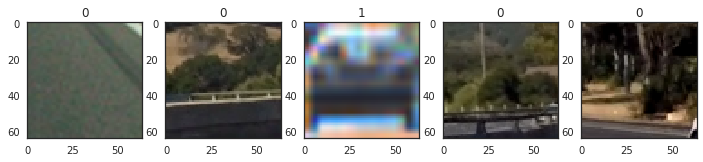

In [21]:
fig = plt.figure(figsize=(12, 6))
for i in range(5):
    image = cv2.imread(pd_SampClass_train['Sample'].iloc[i])
    image = image[:,:,::-1]
    ax = fig.add_subplot(1,5,i+1)
    ax.imshow(image)
    ax.set_title(pd_SampClass_train['Class'].iloc[i])


/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


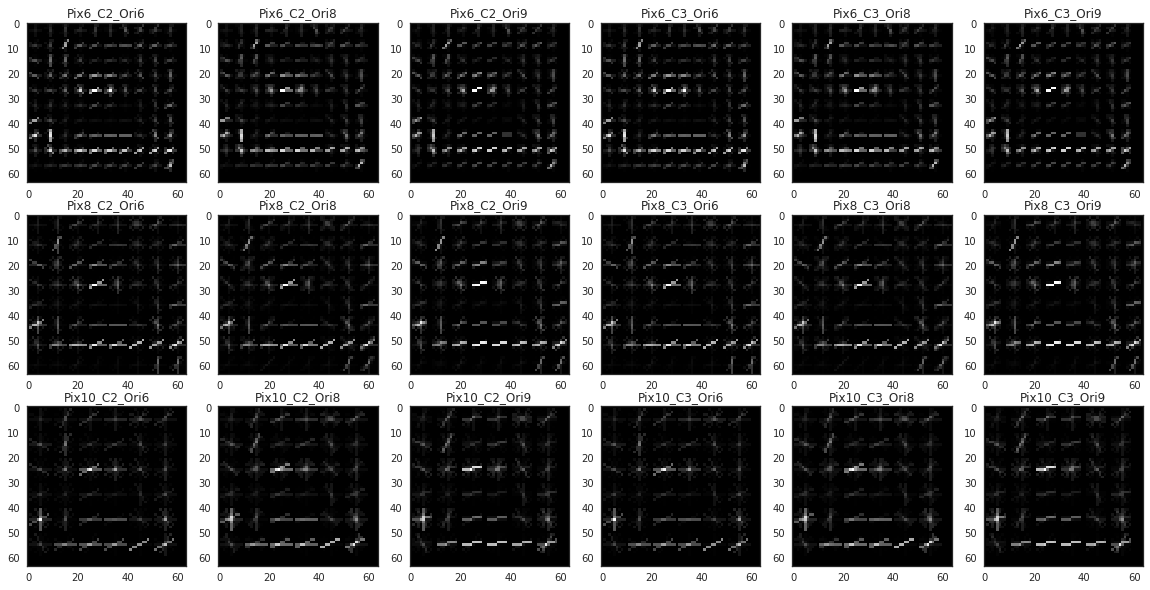

In [22]:
fig = plt.figure(figsize=(20, 10))

img = cv2.imread("./dataset/vehicles/GTI_Far/image0000.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

for i1,pix_per_cell in enumerate([6,8,10]):
    for i2,cell_per_block in enumerate([2,3]):
        for i3,orient in enumerate([6,8,9]):
            features, hog_image = hog(img_gray, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                               cells_per_block=(cell_per_block,cell_per_block),
                               orientations=orient, visualise=True, feature_vector=False
                         )
            #print(features.shape)
            ax = fig.add_subplot(3,6,i1*6+i2*3+i3+1)
            ax.imshow(hog_image, 'gray')
            ax.set_title("Pix%d_C%d_Ori%d" % (pix_per_cell, cell_per_block, orient))

In [23]:
# 这里只看灰度图的轮廓，不考虑颜色。如果需要考虑，这里可以继续添加
l_colorSpace = [cv2.COLOR_BGR2GRAY]
l_names = ["GRAY"]
l_len   = [1]

def get_hog_features(img, orient, pix_per_cell=8, cell_per_block=2,
                        vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def get_features(img, pix_per_cell=8,cell_per_block=2,orient=9, getImage=False, inputFile=True, feature_vec=True):
    l_imgLayers = []
    for cs in l_colorSpace:
        if inputFile:
            l_imgLayers.append(cv2.cvtColor(cv2.imread(img), cs))
        else:
            l_imgLayers.append(cv2.cvtColor(img, cs))

    l_hog_features = []
    l_images = []
    for feature_image in l_imgLayers:
        hog_features = []
        n_channel = 1
        if len(feature_image.shape) > 2:
            n_channel = feature_image.shape[2]
        for channel in range(n_channel):
            featureImg = feature_image
            if n_channel > 2:
                featureImg = feature_image[:,:,channel]

            vout,img = get_hog_features(featureImg,
                                orient, pix_per_cell, cell_per_block,
                                vis=True, feature_vec=feature_vec)
            if getImage:
                l_images.append(img)
            #print(featureImg.shape, vout.shape)
            hog_features.append(vout)

        l_hog_features.append(list(hog_features) )

    if getImage:
        return l_images
    else:
        return functools.reduce(lambda x,y: x+y, l_hog_features)


In [24]:
if os.path.isfile("./X_train.npy") == 0:
    l_X_train = []
    l_X_test  = []
    for r in tqdm(pd_SampClass_train.iterrows()):
        l_X_train.append(np.array(get_features(r[1]['Sample'])).ravel())

    for r in tqdm(pd_SampClass_cv.iterrows()):
        l_X_test.append( np.array(get_features(r[1]['Sample'])).ravel())
    
    X_train = np.array(l_X_train)
    X_test  = np.array(l_X_test)
    np.save("./X_train.npy", X_train)
    np.save("./X_test.npy",  X_test)
else:
    X_train = np.load("./X_train.npy")
    X_test  = np.load("./X_test.npy")

y_train = pd_SampClass_train['Class'].values
y_test  = pd_SampClass_cv['Class'].values

0it [00:00, ?it/s]/root/miniconda3/envs/tencentGPU/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
11899it [02:31, 78.32it/s]
5861it [01:53, 48.78it/s]


In [25]:
X_scalerM = StandardScaler()
X_trainT = X_scalerM.fit_transform(X_train)
X_testT  = X_scalerM.transform(X_test)

X_trainTs,y_trainTs = sklearn.utils.shuffle(X_trainT, y_train)

In [26]:
svc = SVC(random_state=0, C=1)
t=time.time()
svc.fit(X_trainTs, y_trainTs)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

52.65 Seconds to train SVC...


In [27]:
print('Test Accuracy of SVC = ', round(svc.score(X_testT, y_test), 4))
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_testT[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()

pred = svc.predict(X_testT)
print("AUC for Merge dataset = %1.2f,\n" % (roc_auc_score(pred, y_test)))
print(confusion_matrix(pred, y_test))

Test Accuracy of SVC =  0.9869
My SVC predicts:  [1 1 1 0 0 0 0 1 1 1]
For these 10 labels:  [1 1 1 0 0 0 0 1 1 1]
AUC for Merge dataset = 0.99,

[[2929   55]
 [  22 2855]]
